import pickle
import matplotlib.pyplot as plt
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
# Imports

## Libraries

In [1]:
import geopandas
import unidecode
import random
import wikipedia
import warnings
warnings.filterwarnings('ignore')
import shapely
import geopandas as gpd
from shapely.ops import unary_union
# from pysal.esda.mapclassify import User_Defined
import mapclassify as mc

## Data

In [2]:
correct_df = pd.read_csv("./my_saved_data/all_correct_restaurants.csv", index_col=0)

<IPython.core.display.Javascript object>

In [3]:
correct_df.drop(columns = ['Region', "match_boolean"], inplace=True)

In [4]:
correct_df.head()

,City,Match,new_region
chilango,Chicago,chilango,sonora
ocotlan,Chicago,ocotlan,jalisco
tecalitlan,Chicago,tecalitlan,jalisco
teloloapan,Chicago,teloloapan,guerrero
uruapan,Chicago,uruapan,michoacan


In [5]:
with open("./my_saved_data/demonym_dictionary.pickle", "rb+") as f:
    demonym_dict = pickle.load(f)

<IPython.core.display.Javascript object>

# Data Collection

## Count of Restaurants for each city

In [6]:
rest_count_dict = {}

In [7]:
rest_count_dict['Chicago'] = len(correct_df[correct_df['City'] == 'Chicago'])
rest_count_dict['Dallas'] = len(correct_df[correct_df['City'] == 'Dallas'])
rest_count_dict['NYC'] = len(correct_df[correct_df['City'] == 'NYC'])
rest_count_dict['SF'] = len(correct_df[correct_df['City'] == 'SF'])

In [8]:
rest_count_dict

{'Chicago': 5, 'Dallas': 97, 'NYC': 69, 'SF': 13}

## Count of Regions for Each City

In [9]:
def count_regions_in_city(city, df = correct_df):
    city_regions = {}
    city_df = df[df['City'] == city]
    for idx, x in enumerate(city_df.new_region):
        if x in city_regions:
            city_regions[x] += 1
        else:
            city_regions[x] = 1
    return city_regions

In [10]:
nyc_regions = count_regions_in_city("NYC")
dal_regions = count_regions_in_city("Dallas")
sf_regions = count_regions_in_city("SF")
chi_regions = count_regions_in_city("Chicago")

In [11]:
sum(list(nyc_regions.values()))

69

## Percent of restaurants representing a region for each city

In [12]:
regions = list(set(correct_df.new_region))

In [13]:
# sorted(regions)

In [14]:
pct_df = pd.DataFrame(data = regions, columns = ['Region'])

<IPython.core.display.Javascript object>

In [15]:
pct_df.sort_values(by = 'Region', inplace=True)
pct_df.reset_index(inplace=True, drop=True)

In [16]:
def add_regions_for_city_regions_count(city_regions, all_regions = regions):
    for x in regions:
        if x not in city_regions:
            city_regions[x] = 0
    sorted_region_values = [city_regions[key] for key in sorted(city_regions)]
    return sorted_region_values

In [17]:
add_regions_for_city_regions_count(nyc_regions)

[5, 3, 3, 0, 0, 0, 3, 1, 2, 0, 0, 5, 1, 0, 5, 33, 0, 0, 1, 2, 1, 3, 0, 1]

In [18]:
pct_df['NYC'] = add_regions_for_city_regions_count(nyc_regions)
pct_df['Chi'] = add_regions_for_city_regions_count(chi_regions)
pct_df['Dal'] = add_regions_for_city_regions_count(dal_regions)
pct_df['SF'] = add_regions_for_city_regions_count(sf_regions)

In [19]:
pct_df['NYC_pct'] = round(pct_df['NYC'] / sum(list(nyc_regions.values())), 2)
pct_df['Chi_pct'] = round(pct_df['Chi'] / sum(list(chi_regions.values())), 2)
pct_df['Dal_pct'] = round(pct_df['Dal'] / sum(list(dal_regions.values())), 2)
pct_df['SF_pct'] = round(pct_df['SF'] / sum(list(sf_regions.values())), 2)

In [20]:
pct_df.head(2)

,Region,NYC,Chi,Dal,SF,NYC_pct,Chi_pct,Dal_pct,SF_pct
0,baja california,5,0,1,0,0.07,0.0,0.01,0.00
1,chihuahua,3,0,2,1,0.04,0.0,0.02,0.08


## Most prevalent regions for each city

In [21]:
pct_df.sort_values(by=['NYC_pct'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF,NYC_pct,Chi_pct,Dal_pct,SF_pct
15,puebla,33,0,1,0,0.48,0.0,0.01,0.00
0,baja california,5,0,1,0,0.07,0.0,0.01,0.00
14,oaxaca,5,0,2,0,0.07,0.0,0.02,0.00
11,morelos,5,0,0,0,0.07,0.0,0.00,0.00
1,chihuahua,3,0,2,1,0.04,0.0,0.02,0.08


In [22]:
pct_df.sort_values(by=['Chi_pct'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF,NYC_pct,Chi_pct,Dal_pct,SF_pct
8,jalisco,2,2,8,3,0.03,0.4,0.08,0.23
19,sonora,2,1,1,0,0.03,0.2,0.01,0.00
6,guerrero,3,1,11,2,0.04,0.2,0.11,0.15
10,michoacan,0,1,35,0,0.00,0.2,0.36,0.00
0,baja california,5,0,1,0,0.07,0.0,0.01,0.00


In [23]:
pct_df.sort_values(by=['Dal_pct'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF,NYC_pct,Chi_pct,Dal_pct,SF_pct
10,michoacan,0,1,35,0,0.00,0.2,0.36,0.00
13,nuevo leon,0,0,13,0,0.00,0.0,0.13,0.00
6,guerrero,3,1,11,2,0.04,0.2,0.11,0.15
8,jalisco,2,2,8,3,0.03,0.4,0.08,0.23
5,guanajuato,0,0,6,0,0.00,0.0,0.06,0.00


In [24]:
pct_df.sort_values(by=['SF_pct'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF,NYC_pct,Chi_pct,Dal_pct,SF_pct
2,ciudad de mexico,3,0,1,3,0.04,0.0,0.01,0.23
8,jalisco,2,2,8,3,0.03,0.4,0.08,0.23
22,yucatan,0,0,1,2,0.00,0.0,0.01,0.15
6,guerrero,3,1,11,2,0.04,0.2,0.11,0.15
18,sinaloa,1,0,0,1,0.01,0.0,0.00,0.08


## Regions That are Over 20% of a city's mex restaurants 

In [25]:
over_20_regions = ['puebla', 'jalisco', 'michoacan', 'ciudad de mexico']

In [26]:
over_20_df = pct_df[pct_df['Region'].isin(over_20_regions)][['Region',"Chi_pct", "Dal_pct", 'NYC_pct', "SF_pct"]]

In [27]:
over_20_df

,Region,Chi_pct,Dal_pct,NYC_pct,SF_pct
2,ciudad de mexico,0.0,0.01,0.04,0.23
8,jalisco,0.4,0.08,0.03,0.23
10,michoacan,0.2,0.36,0.00,0.00
15,puebla,0.0,0.01,0.48,0.00


## Saving Data 

In [28]:
# pct_df.to_csv("./my_saved_data/corrected_pct_df.csv")
# over_20_df.to_csv("./my_saved_data/regions_over_20_pct_of_city.csv")

# Displaying Data

## Geodataframe

In [25]:
# shapefile issue fixed here: https://github.com/Toblerity/Fiona/issues/548 
# and https://stackoverflow.com/questions/61436956/set-shape-restore-shx-config-option-to-yes-to-restore-or-create-it
mex_gdf = geopandas.read_file("./data/MEX_adm1.shp")

In [26]:
mex_gdf.plot()

### Removing Unnecessary columns

In [27]:
mex_gdf.drop(columns = ['ID_0', 'ID_1', 'ISO', 'NAME_0', 'HASC_1', 'CC_1', 'VALIDFR_1', 'VALIDTO_1', 'REMARKS_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1'], inplace=True)

In [28]:
regions_for_gdf = [unidecode.unidecode(x) for x in mex_gdf['NAME_1']]
mex_gdf['Region'] = [x.lower() for x in regions_for_gdf]

### Adding pct_df data

In [33]:
# truly missing regions are: queretaro, coahuila, quintana roo
for x in mex_gdf['Region']:
    if x not in regions:
        print(x)

aguascalientes
baja california sur
campeche
chiapas
colima
distrito federal
queretaro
tabasco
tlaxcala


#### Renaming 2 regions in pct_df

In [34]:
pct_df['Region'][2] = 'distrito federal'

#### Joining the two 

In [35]:
mex_gdf2 = mex_gdf.merge(pct_df, left_on = 'Region', right_on = 'Region', how='outer')
mex_gdf2.fillna(value = 0, inplace=True, axis=1)

In [40]:
mex_gdf2.head(2)

,NAME_1,Shape_Leng,Shape_Area,geometry,Region,NYC,Chi,Dal,SF,NYC_pct,Chi_pct,Dal_pct,SF_pct
0,Aguascalientes,2.805224,0.455085,"POLYGON ((-102.12611 21.73960, -102.13392 21.7...",aguascalientes,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
1,Baja California,30.144683,6.935158,"MULTIPOLYGON (((-114.75681 18.37097, -114.7568...",baja california,5.0,0.0,1.0,0.0,0.07,0.0,0.01,0.0


## Choropleth maps
consistent scale: https://github.com/geopandas/geopandas/issues/1019

### Consistent scale

In [41]:
bin_range_times10 = list(range(0, 5))
bin_range = np.array(bin_range_times10) / 10

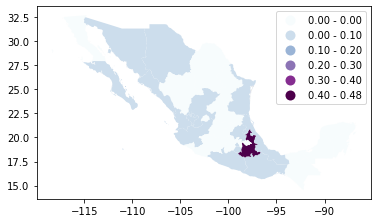

In [42]:
# NYC 
mex_gdf2.plot(column='NYC_pct', legend=True, cmap='BuPu', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

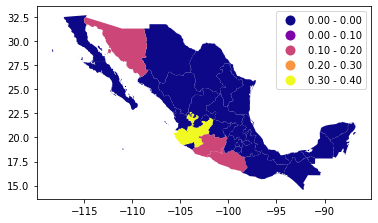

In [43]:
# chicago
mex_gdf2.plot(column='Chi_pct', legend=True, cmap = 'plasma',scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

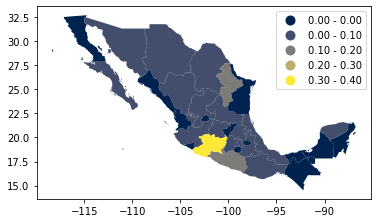

In [44]:
# dal
mex_gdf2.plot(column='Dal_pct', legend=True, cmap = 'cividis',
              scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

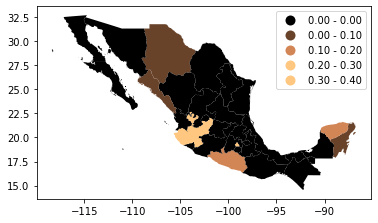

In [45]:
# sf
mex_gdf2.plot(column='SF_pct', legend=True, cmap = 'copper',scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

### Plotting all cities together
multiple axes: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

<IPython.core.display.Javascript object>

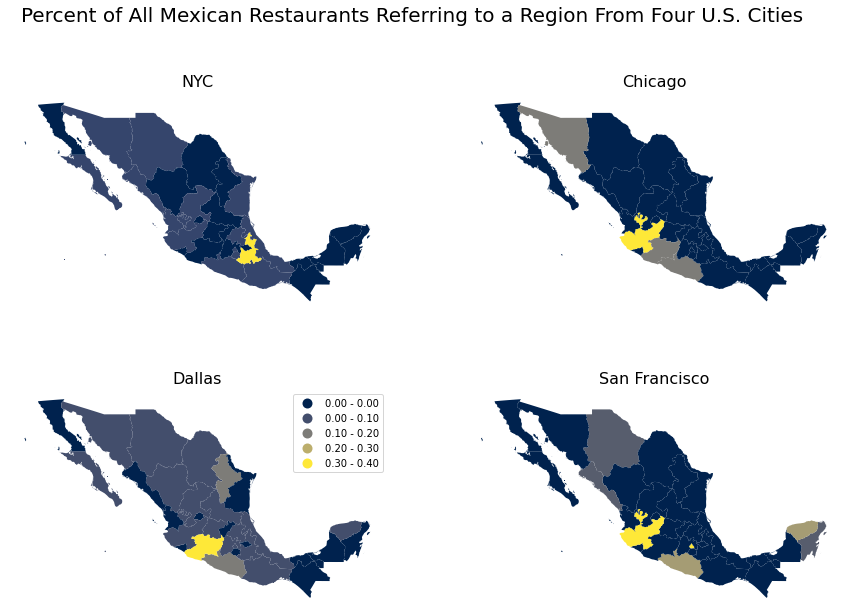

In [46]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)
mex_gdf2.plot(
    column='NYC_pct', ax=ax1, cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax1.set_title('NYC', fontsize=16)
mex_gdf2.plot(
    column='Chi_pct', ax=ax2, cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax2.set_title('Chicago', fontsize=16)
mex_gdf2.plot(
    column='Dal_pct', ax=ax3,  cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range), legend=True)
ax3.set_title('Dallas', fontsize=16)
mex_gdf2.plot(
    column='SF_pct', ax=ax4,cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax4.set_title('San Francisco', fontsize=16)
for ax in (ax1,ax2,ax3,ax4,):
    ax.axis('off')
# plt.savefig("./my_saved_data/Map_of_regions_from_all_cities.png", pad_inches='tight', orientation='landscape')

## Percent of Restaurants that Have a Region Associated With Them

In [47]:
#NYC had 849 unique mexican restaurants, 69 matched
print(rest_count_dict)
print(f"The percent of restaurants that had a name attached to a region was {round(69/849, 2) * 100}%")

{'Chicago': 5, 'Dallas': 97, 'NYC': 69, 'SF': 13}
The percent of restaurants that had a name attached to a region was 8.0%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

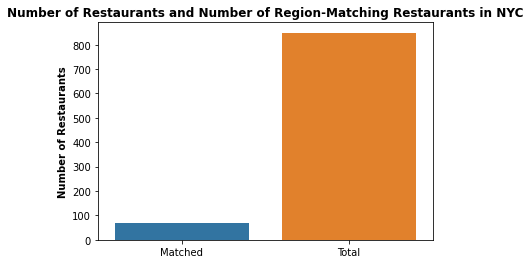

In [94]:
ax = sns.barplot(x=['Matched', 'Total'], y=[69, 849])
ax.set_title('Number of Restaurants and Number of Region-Matching Restaurants in NYC', fontsize='large', fontweight='bold')
ax.set_ylabel("Number of Restaurants", fontweight='bold')
plt.savefig("./my_saved_data/Matched_restaurants_vs_total.png", bbox_inches='tight')

## Most Diverse Mexican Population

In [49]:
nunique_restaurants = correct_df.groupby(['City']).new_region.count()
list(nunique_restaurants)

[5, 97, 69, 13]

In [50]:
nunique_regions = correct_df.groupby(['City']).new_region.nunique()
list(nunique_regions)

[4, 19, 15, 7]

In [51]:
nunique_regions.keys()

Index(['Chicago', 'Dallas', 'NYC', 'SF'], dtype='object', name='City')

In [52]:
pct_unique = np.array(list(nunique_regions)) / np.array(list(nunique_restaurants))
pct_unique

array([0.8       , 0.19587629, 0.2173913 , 0.53846154])

In [53]:
pct_unique_dict = dict(zip(nunique_regions.keys(), pct_unique))
pct_unique_dict

{'Chicago': 0.8,
 'Dallas': 0.1958762886597938,
 'NYC': 0.21739130434782608,
 'SF': 0.5384615384615384}

### Saving Diversity of Restaurants Dict

In [54]:
# with open ('./my_saved_data/restaurant_region_diversity.pickle', 'wb+') as f:
#     pickle.dump(pct_unique_dict, f)

## Most diverse city with sample of restaurants

In [55]:
# sample 32 restaurants from each city and see which one has the most regions appear 
all_ind_restaurants = correct_df.copy()

In [56]:
# exclude chicago restaurants because there are only 5 for them
all_ind_restaurants_no_chi = all_ind_restaurants[all_ind_restaurants['City'] != 'Chicago'].reset_index()
all_ind_restaurants_no_chi.head(2)

,index,City,Match,new_region
0,acapulco,Dallas,acapulco,guerrero
1,antojito's jalisco,Dallas,jalisco,jalisco


In [62]:
# regions match between demonym dict and all_ind_restaurants_no_chi['Region']
lower_demonym_dict_keys = [x.lower() for x in list(demonym_dict.keys())]
## fixing mistaken keys
lower_demonym_dict_keys.remove('michoacan de ocampo')
lower_demonym_dict_keys.append('michoacan')
lower_demonym_dict_keys.remove('coahuila de zaragoza')
lower_demonym_dict_keys.append('coahuila')
# checking that all keys in all_ind_restaurants_no_chi['new_region'] are in keys
for region in all_ind_restaurants_no_chi['new_region']:
    if region not in lower_demonym_dict_keys:
        print(region)

In [60]:
# sorted(lower_demonym_dict_keys)

In [65]:
def select_random_restaurants(city, df=all_ind_restaurants_no_chi, all_regions = lower_demonym_dict_keys):
    new_df = df[df['City'] == city].reset_index()
    region_dict = {key:0 for key in all_regions}
    random_nums = []
    while len(random_nums) < 10:
        random_number = random.randint(0, len(new_df)-1)
        if random_number not in random_nums:
            random_nums.append(random_number)
    for number in random_nums:
        region = new_df['new_region'][number]
        region_dict[region] += 1
    return region_dict

In [66]:
def count_random_regions(region_dict):
    region_counter = 0
    for key, value in region_dict.items():
        if value > 0:
            region_counter += 1
    return region_counter

In [67]:
def get_10_samples_of_rand_regions(city, df=all_ind_restaurants_no_chi, all_regions = lower_demonym_dict_keys):
    region_count_list = []
    while len(region_count_list) < 30:
        rest_dict = select_random_restaurants(city)
        rand_region_count = count_random_regions(rest_dict)
        region_count_list.append(rand_region_count)
    mean_region_count = sum(region_count_list) / len(region_count_list)
    return round(mean_region_count, 1)

In [68]:
dal_rest_count_mean = get_10_samples_of_rand_regions("Dallas")
dal_rest_count_mean

6.1

In [69]:
nyc_rest_count_mean = get_10_samples_of_rand_regions("NYC")
nyc_rest_count_mean

5.4

In [3]:
# there are only 13 restaurants in san francisco... too small of a sample 
# sf_rest_count_mean = get_10_samples_of_rand_regions("SF")
# sf_rest_count_mean

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

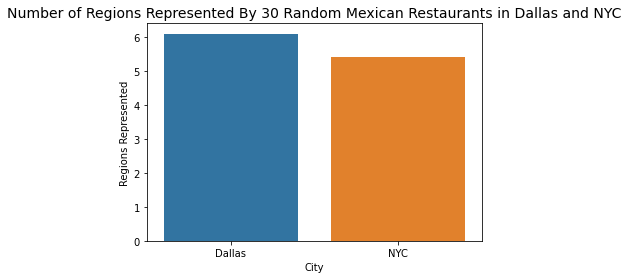

In [74]:
ax = sns.barplot(x = ['Dallas', "NYC"], y = [6.1, 5.4])
ax.set_title("Number of Regions Represented By 30 Random Mexican Restaurants in Dallas and NYC", fontsize=14)
ax.set_ylabel("Regions Represented")
ax.set_xlabel("City")
# plt.savefig("./my_saved_data/Count_of_regions_for_sampled_restaurants.png", bbox_inches='tight')

## Count of matching Restaurants Across Cities

In [75]:
cities = list(nunique_regions.keys())

In [76]:
num_of_restaurants = list(nunique_restaurants)
num_of_restaurants

[5, 97, 69, 13]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Cities')

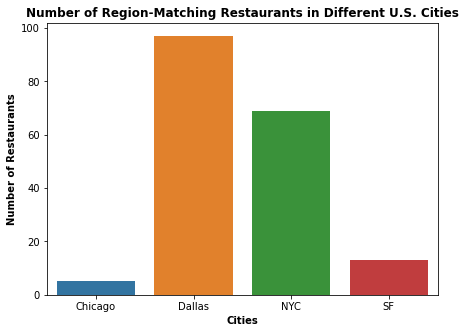

In [77]:
fig= plt.subplots(figsize=(7, 5))
ax = sns.barplot(x = cities, y = num_of_restaurants)
ax.set_title('Number of Region-Matching Restaurants in Different U.S. Cities', fontsize='large',
             fontweight='bold')
ax.set_ylabel("Number of Restaurants", fontweight='bold')
ax.set_xlabel("Cities", fontweight='bold')
# plt.savefig("./my_saved_data/number_of_restaurants_for_each_city.png", pad_inches='tight')

# Considering All Data Together

In [78]:
count_of_all_restaurants_each_region = {key:0 for key in correct_df['new_region'].unique()}

In [79]:
for x in correct_df['new_region']:
    count_of_all_restaurants_each_region[x] += 1

In [80]:
all_rest_df = pd.DataFrame.from_dict(count_of_all_restaurants_each_region, orient = 'index').reset_index()

<IPython.core.display.Javascript object>

In [81]:
all_rest_df.columns = ['Region', 'Count']

In [82]:
all_rest_df['Percent_of_all_rest'] = round(all_rest_df['Count'] / sum(all_rest_df['Count']), 2)

In [83]:
all_rest_df.sort_values(by = ['Percent_of_all_rest'], ascending=False).head(10)

,Region,Count,Percent_of_all_rest
3,michoacan,36,0.20
15,puebla,34,0.18
2,guerrero,17,0.09
1,jalisco,15,0.08
5,nuevo leon,13,0.07
14,oaxaca,7,0.04
11,ciudad de mexico,7,0.04
21,morelos,5,0.03
16,veracruz,6,0.03
8,chihuahua,6,0.03


### Matching mex_gdf regions with regions in all_rest_df

In [84]:
for x in all_rest_df.Region:
    if x not in list(mex_gdf.Region):
        print(x)

ciudad de mexico


In [85]:
mex_gdf['Region'][8] = 'ciudad de mexico'

### Merging

In [86]:
mex_gdf3 = mex_gdf.merge(all_rest_df, left_on = 'Region', right_on = 'Region', how='outer')

In [87]:
mex_gdf3.fillna(value = 0, inplace=True)

## Plotting

In [88]:
bin_range_times13 = list(range(0, 21, 5))
bin_range13 = np.array(bin_range_times13) / 100

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

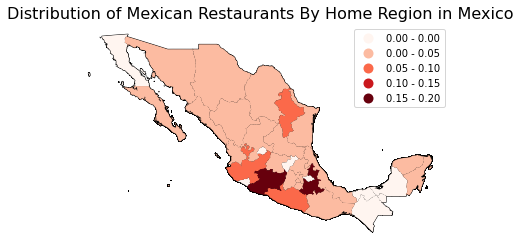

In [98]:
fig, ax = plt.subplots(1, figsize=(8,4))
# fig.title('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)
ax.set_aspect('equal')
mex_gdf3.plot(color='white', edgecolor='black', ax=ax)

mex_gdf3.plot(column='Percent_of_all_rest', cmap = 'Reds', legend=True, 
              scheme='User_Defined', ax=ax,
              classification_kwds=dict(bins=bin_range13))
ax.set_title("Distribution of Mexican Restaurants By Home Region in Mexico",fontsize=16)
ax.axis('off')
# plt.savefig("./my_saved_data/Map_of_all_restaurants_and_their_regions.png", pad_inches='tight', orientation='landscape')

## Comparison to remittances per person in Mexico

### Getting populations for each state 

In [366]:
# used https://wikitable2csv.ggor.de and https://en.wikipedia.org/wiki/Ranked_list_of_Mexican_states to get data
mex_pop = pd.read_csv("./data/mex_population_by_state.csv")

<IPython.core.display.Javascript object>

In [369]:
mex_pop.drop([0], inplace=True)

#### Making names in table match gdf names

In [389]:
gdf_region_names = list(mex_gdf['NAME_1'])
wiki_region_names = [x for x in mex_pop['State']]
for x in gdf_region_names: # finding mismatches 
    if x not in wiki_region_names:
        print(x)

In [394]:
mex_pop.replace(to_replace = 'Mexico State', value = 'México', inplace=True)
mex_pop.replace(to_replace = 'Ciudad de México', value = 'Distrito Federal', inplace=True)

#### Combining population data to mex_gdf

In [395]:
mex_gdf_pop = mex_gdf.merge(mex_pop, left_on = 'NAME_1', right_on = 'State', how='outer')

In [429]:
mex_gdf_pop.head()

,NAME_1,Shape_Leng,Shape_Area,geometry,Region,Rank,State,Population,%,Density,Population_num
0,Aguascalientes,2.805224,0.455085,"POLYGON ((-102.12611 21.73960, -102.13392 21.7...",aguascalientes,26,Aguascalientes,"1,023,800",1.0%,183.2,1023800
1,Baja California,30.144683,6.935158,"MULTIPOLYGON (((-114.75681 18.37097, -114.7568...",baja california,13,Baja California,"2,846,500",2.8%,40.6,2846500
2,Baja California Sur,56.643081,6.425989,"MULTIPOLYGON (((-114.23174 27.88559, -114.2308...",baja california sur,31,Baja California Sur,"763,929",0.5%,6.5,763929
3,Campeche,19.770113,4.928100,"MULTIPOLYGON (((-91.79708 18.51764, -91.79708 ...",campeche,29,Campeche,"720,900",0.7%,13.9,720900
4,Chiapas,18.455889,6.232582,"MULTIPOLYGON (((-92.86236 15.16819, -92.86236 ...",chiapas,6,Chiapas,"4,329,700",4.2%,58.6,4329700


### Plotting Population of each state

#### Population range

In [407]:
mex_gdf_pop['Population_num'] = [int("".join(x.split(","))) for x in mex_gdf_pop['Population']]
# mex_gdf_pop['Population'].split(",").join()

In [430]:
mex_gdf_pop['Population_num_100_thousandthds'] = mex_gdf_pop['Population_num'] / 100000

In [409]:
# getting range of population
print(mex_gdf_pop['Population_num'].max())
print(mex_gdf_pop['Population_num'].min())

16187608
581100


In [440]:
bin_range_pop_100000 = list(range(500000, 16500000, 5000000))
bin_range_pop = np.array(bin_range_pop_100000) / 100000

#### Plot

<IPython.core.display.Javascript object>

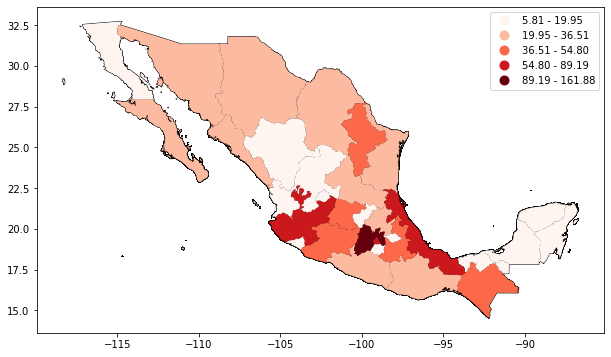

In [447]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.set_aspect('equal')
mex_gdf_pop.plot(color='white', edgecolor='black', ax=ax)

mex_gdf_pop.plot(column='Population_num_100_thousandthds', legend=True, cmap='Reds', ax=ax,
                 scheme = 'naturalbreaks')

### Plotting remittances per person

#### Importing Data

In [468]:
remit_df = pd.read_excel("./data/remittances_2020.xlsx", header=7)
remit_df.columns = ['X', "State", "Oct-Dec 2019", "Jan-Mar 2020", "Y"]

<IPython.core.display.Javascript object>

In [469]:
remit_df.drop(columns = ['X', 'Y'], inplace=True)

In [470]:
remit_df.drop([0, 1, 2, 35, 36, 37], inplace=True)
remit_df.reset_index(inplace=True, drop=True)

#### Cleaning State Names

In [484]:
new_state_names = []
for state in remit_df['State']:
    for idx, x in enumerate(state):
        if x.isalpha() == True:
            new_state_names.append(state[idx:])
            break

In [495]:
remit_df['Simplified_state'] = new_state_names
remit_df.replace(to_replace='Ciudad de México', value = 'Distrito Federal', inplace=True)
remit_df.replace(to_replace='Estado de México', value = 'México', inplace=True)

In [508]:
remit_df.sort_values(by=['Simplified_state'], inplace=True)
remit_df.reset_index(drop=True, inplace=True)

In [524]:
first_half = list(range(0, 14))
last_half = list(range(17, len(remit_df) + 1))
first_half.extend([16, 14, 15])
first_half.extend(last_half)
remit_df2 = remit_df.reindex(first_half)

In [525]:
print(first_half)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [526]:
remit_df2

,State,Oct-Dec 2019,Jan-Mar 2020,Simplified_state
0,● Aguascalientes,126.255446,126.428640,Aguascalientes
1,● Baja California,234.440825,261.319139,Baja California
2,● Baja California Sur,22.866894,22.056848,Baja California Sur
3,● Campeche,21.579100,23.656777,Campeche
4,● Chiapas,233.420129,247.823529,Chiapas
5,● Chihuahua,274.673968,281.986885,Chihuahua
6,● Coahuila,162.099650,158.873674,Coahuila
7,● Colima,79.214818,82.335616,Colima
8,● Ciudad de México,433.970210,475.026413,Distrito Federal
9,● Durango,223.854965,212.433612,Durango


#### Adding remittance data to mex_gdf_pop

In [529]:
wikipedia_and_remit_regions = list(zip(mex_gdf_pop['State'], remit_df2['Simplified_state']))
# wikipedia_and_remit_regions

In [536]:
mex_gdf_pop['Remittances_2020_Q1'] = remit_df2['Jan-Mar 2020']

In [537]:
mex_gdf_pop.head()

,NAME_1,Shape_Leng,Shape_Area,geometry,Region,Rank,State,Population,%,Density,Population_num,Population_num_100_thousandthds,Remittances_2020_Q1
0,Aguascalientes,2.805224,0.455085,"POLYGON ((-102.12611 21.73960, -102.13392 21.7...",aguascalientes,26,Aguascalientes,"1,023,800",1.0%,183.2,1023800,10.23800,126.428640
1,Baja California,30.144683,6.935158,"MULTIPOLYGON (((-114.75681 18.37097, -114.7568...",baja california,13,Baja California,"2,846,500",2.8%,40.6,2846500,28.46500,261.319139
2,Baja California Sur,56.643081,6.425989,"MULTIPOLYGON (((-114.23174 27.88559, -114.2308...",baja california sur,31,Baja California Sur,"763,929",0.5%,6.5,763929,7.63929,22.056848
3,Campeche,19.770113,4.928100,"MULTIPOLYGON (((-91.79708 18.51764, -91.79708 ...",campeche,29,Campeche,"720,900",0.7%,13.9,720900,7.20900,23.656777
4,Chiapas,18.455889,6.232582,"MULTIPOLYGON (((-92.86236 15.16819, -92.86236 ...",chiapas,6,Chiapas,"4,329,700",4.2%,58.6,4329700,43.29700,247.823529


In [539]:
mex_gdf_pop['Remittances_per_person'] = mex_gdf_pop['Population_num'] / mex_gdf_pop['Remittances_2020_Q1']

In [559]:
total_remit = mex_gdf_pop['Remittances_2020_Q1'].sum()

In [560]:
total_remit

9297.128517000001

In [563]:
mex_gdf_pop['Remittances_as_pct_of_total'] = round(mex_gdf_pop['Remittances_2020_Q1'] / total_remit, 2)

### Plotting Remittances per person 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

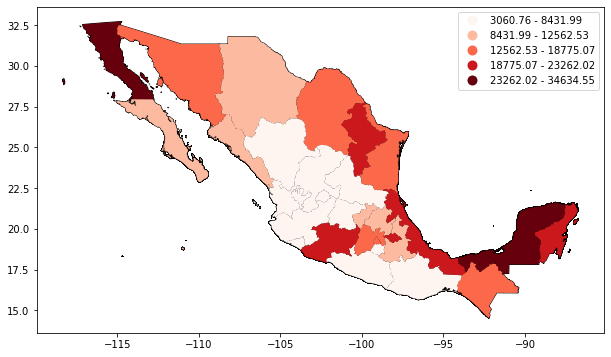

In [544]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.set_aspect('equal')
mex_gdf_pop.plot(color='white', edgecolor='black', ax=ax)

mex_gdf_pop.plot(column='Remittances_per_person', legend=True, cmap='Reds', ax=ax,
                 scheme = 'naturalbreaks')
# plt.savefig("./my_saved_data/Remittance_per_person.png", pad_inches='tight', orientation='landscape')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

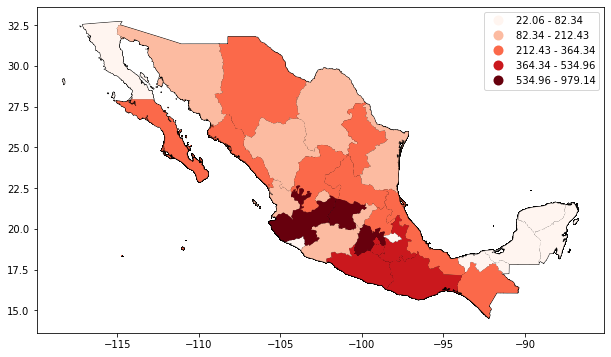

In [545]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.set_aspect('equal')
mex_gdf_pop.plot(color='white', edgecolor='black', ax=ax)

mex_gdf_pop.plot(column='Remittances_2020_Q1', legend=True, cmap='Reds', ax=ax,
                 scheme = 'naturalbreaks')
# plt.savefig("./my_saved_data/Total_remittances.png", pad_inches='tight', orientation='landscape')

<IPython.core.display.Javascript object>

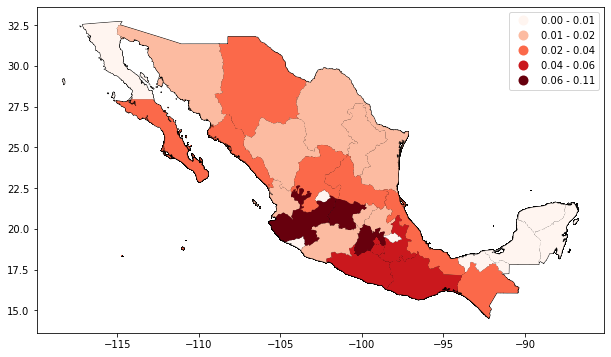

In [565]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.set_aspect('equal')
mex_gdf_pop.plot(color='white', edgecolor='black', ax=ax)

mex_gdf_pop.plot(column='Remittances_as_pct_of_total', legend=True, cmap='Reds', ax=ax,
                 scheme = 'naturalbreaks')

### Plotting remittances and regions represented in rest. names

In [575]:
bin_range_remit = list(range(0, 12, 3))
bin_range_remit_array = np.array(bin_range_remit) / 100

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

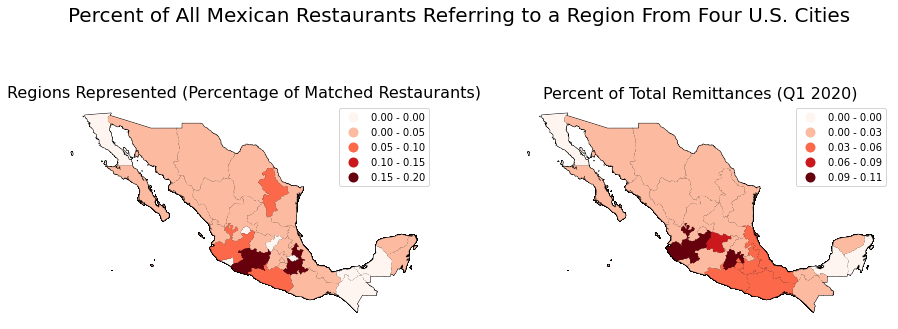

In [578]:
fig,((ax1, ax2)) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)

ax1.set_aspect('equal')
mex_gdf_pop.plot(color='white', edgecolor='black', ax=ax1)

mex_gdf3.plot(column='Percent_of_all_rest', cmap = 'Reds', legend=True, 
              scheme='User_Defined', ax=ax1,
              classification_kwds=dict(bins=bin_range13))
# ax.set_title("Distribution of Mexican Restaurants By Home Region in Mexico",fontsize=16)

# mex_gdf_pop.plot(column='Population_num_100_thousandthds', legend=True, cmap='Reds', ax=ax1,
#                  scheme = 'naturalbreaks')
ax1.set_title('Regions Represented (Percentage of Matched Restaurants)', fontsize=16)

ax2.set_aspect('equal')
mex_gdf_pop.plot(color='white', edgecolor='black', ax=ax2)
mex_gdf_pop.plot(column='Remittances_as_pct_of_total', legend=True, cmap='Reds', ax=ax2,
                 scheme='User_Defined', classification_kwds=dict(bins=bin_range_remit_array))
ax2.set_title('Percent of Total Remittances (Q1 2020)', fontsize=16)

for ax in (ax1,ax2,):
    ax.axis('off')
# plt.savefig("./my_saved_data/Regions_represented_plus_remittances_pct.png", pad_inches='tight', orientation='landscape')

In [ ]:
# there is a lot of overlap between the regions heavily represented and the remittances sent to mexico

# Culinary Regions of Mexico

In [12]:
# according to https://www.picos.net/the-seven-regions-of-mexican-cuisine/
cul_reg_dict = {"North": ['Baja California', "Baja California Sur",
                         "Sonora", "Chihuahua", "Coahuila", "Durango",
                         'Zacatecas', "Aguascalientes", "Nuevo Leon", 
                          'Tamaulipas'],
                "North Pacific Coast": ['Sinaloa', 'Nayarit', 'Jalisco',
                                       'Colima'],
                "Bajio": ['Michoacan', "Michoacan de Ocampo", 
                          'Guanajuato', 'San Luis Potosi', 'Queretaro'],
                "South Pacific Coast": ['Guerrero', 'Oaxaca', 'Chiapas'],
                "South": ['Campeche', "Yucatan", "Quintana Roo"],
                "Gulf": ['Tabasco', 'Veracruz'],
                "Central": ['Mexico', 'Puebla', 'Morelos', 'Tlaxcala', "Hidalgo",
                           'Ciudad de Mexico', "Distrito Federal", 'Ciudad De Mexico']
}

In [13]:
all_rest_df = pd.read_csv("./my_saved_data/all_restaurants_df.csv", index_col = 0)

<IPython.core.display.Javascript object>

## Getting Overall picture of culinary regions and regions represented in all cities 

In [30]:
cul_reg_count = {}
for cul_region, value in cul_reg_dict.items():
    if cul_reg_count.get(cul_region) == None:
        cul_reg_count[cul_region] = 0
    for rest_count in value:
        for idx, region in enumerate(all_rest_df.index):
            if region == rest_count:
                cul_reg_count[cul_region] += all_rest_df.Count_of_restaurants[idx]

In [31]:
for key, value in cul_reg_count.items():
    cul_reg_count[key] = [value, round((value / all_rest_df.Count_of_restaurants.sum()), 2)]

In [32]:
sort_cul_reg_count = sorted(cul_reg_count.items(), key=lambda x: x[1], reverse=True)

### print percent of total in a culinary region map


In [35]:
# making sure that all region names in dict are in mex_gdf
gdf_regions = list(mex_gdf.Region)
for key, value in cul_reg_dict.items():
    for region in value:
        lower_region = region.lower()
        if lower_region not in gdf_regions:
            print(lower_region)

michoacan de ocampo
ciudad de mexico
ciudad de mexico


In [37]:
# making sure that all region names in mex_gdf are in dict 
lower_regions = [x.lower() for value in cul_reg_dict.values() for x in value]
for region in mex_gdf.Region:
    if region not in lower_regions:
        print(region)

In [42]:
super_region_list = []
for region in super_mex_gdf['Region']:
    for super_region, sub_region in cul_reg_dict.items():
        if region.title() in sub_region:
            super_region_list.append(super_region)

In [43]:
super_mex_gdf = mex_gdf.copy()
super_mex_gdf['Culinary_region'] = super_region_list

In [44]:
super_region_df = pd.DataFrame(data = sort_cul_reg_count, columns = ['Region', "Raw_Count"])
super_region_df.set_index(['Region'], inplace=True)

<IPython.core.display.Javascript object>

In [45]:
# make order the same as it is in the dict 
super_region_df2 = super_region_df.reindex(list(cul_reg_count.keys()))

In [46]:
super_region_df2['Count'] = [x[0] for x in super_region_df2['Raw_Count']]
super_region_df2['Percent_of_total'] = [x[1] for x in super_region_df2['Raw_Count']]

In [47]:
# Combine culinary_regions into geometries
polygon_list = []
for key in cul_reg_dict.keys():
    polygon = []
    for idx, cul_region in enumerate(super_mex_gdf.Culinary_region):
        if key == cul_region:
            polygon.append(super_mex_gdf.geometry[idx])
    polygon_list.append(polygon)
combined_polygon_list = []
for x in polygon_list:
    boundary = gpd.GeoSeries(unary_union(x)) 
    combined_polygon_list.append(boundary)
# boundary = gpd.GeoDataFrame([unary_union(x) for x in polygon_list])

In [48]:
super_region_df2['geometry'] = [x.values[0] for x in combined_polygon_list]

In [49]:
super_region_gdf = gpd.GeoDataFrame(super_region_df2, geometry = super_region_df2.geometry)

In [50]:
bin_range_to20 = list(range(0, 25, 5))
bin_range_gdf = np.array(bin_range_to20) / 100

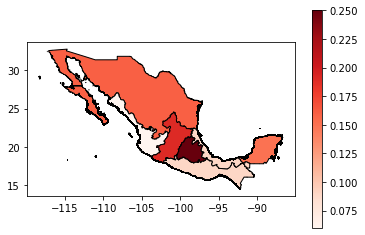

In [51]:
super_region_gdf.plot(column='Percent_of_total', legend=True, cmap='Reds', edgecolor='black')
# , scheme='User_Defined',
#               classification_kwds=dict(bins=bin_range_gdf), edgecolor='gray')

## Culinary regions for each city

In [52]:
nyc_regions = count_regions_in_city("NYC")
dal_regions = count_regions_in_city("Dallas")
sf_regions = count_regions_in_city("SF")
chi_regions = count_regions_in_city("Chicago")

In [53]:
def turn_city_regions_to_cul_regions(city_regions, cul_regions=cul_reg_dict):
    city_cul_regions = {key:0 for key in cul_regions.keys()}
    for key, value in city_regions.items():
        for key2, value2 in cul_regions.items():
            if key.title() in value2:
                city_cul_regions[key2] += value
    return city_cul_regions

In [54]:
nyc_cul_regions = turn_city_regions_to_cul_regions(nyc_regions)
dal_cul_regions = turn_city_regions_to_cul_regions(dal_regions)
sf_cul_regions = turn_city_regions_to_cul_regions(sf_regions)
chi_cul_regions = turn_city_regions_to_cul_regions(chi_regions)

In [57]:
for x in [nyc_cul_regions, dal_cul_regions, sf_cul_regions, chi_cul_regions]:
    print(list(sorted(x.items(), key=lambda x: x[1], reverse=True))[0:3])

[('Central', 42), ('North', 12), ('South Pacific Coast', 8)]
[('Bajio', 43), ('North', 21), ('South Pacific Coast', 13)]
[('North Pacific Coast', 4), ('South', 3), ('Central', 3)]
[('North Pacific Coast', 2), ('North', 1), ('Bajio', 1)]


### Printing All Cul Regions Together 

In [58]:
# new mex_gdf
super_region_gdf3 = super_region_gdf.copy()

In [59]:
super_region_gdf3['NYC'] = nyc_cul_regions.values()
super_region_gdf3['Dal'] = dal_cul_regions.values()
super_region_gdf3['SF'] = sf_cul_regions.values()
super_region_gdf3['Chi'] = chi_cul_regions.values()

In [60]:
super_region_gdf3['NYC_pct'] = [round(x / super_region_gdf3['NYC'].sum(), 2) for x in super_region_gdf3['NYC']]
super_region_gdf3['Dal_pct'] = [round(x / super_region_gdf3['Dal'].sum(), 2) for x in super_region_gdf3['Dal']]
super_region_gdf3['SF_pct'] = [round(x / super_region_gdf3['SF'].sum(), 2) for x in super_region_gdf3['SF']]
super_region_gdf3['Chi_pct'] = [round(x / super_region_gdf3['Chi'].sum(), 2) for x in super_region_gdf3['Chi']]

In [61]:
# new bin range 
bin_range_70_list = list(range(0, 70, 15))
bin_range_70 = np.array(bin_range_70_list) / 100

In [62]:
ud = mc.UserDefined(super_region_gdf3['NYC_pct'], bin_range_70)

In [63]:
ud

UserDefined         

  Interval     Count
--------------------
[0.00, 0.00] |     2
(0.00, 0.15] |     3
(0.15, 0.30] |     1
(0.30, 0.45] |     0
(0.45, 0.60] |     0
(0.60, 0.61] |     1

In [64]:
print(gpd.__version__)

0.8.1


<IPython.core.display.Javascript object>

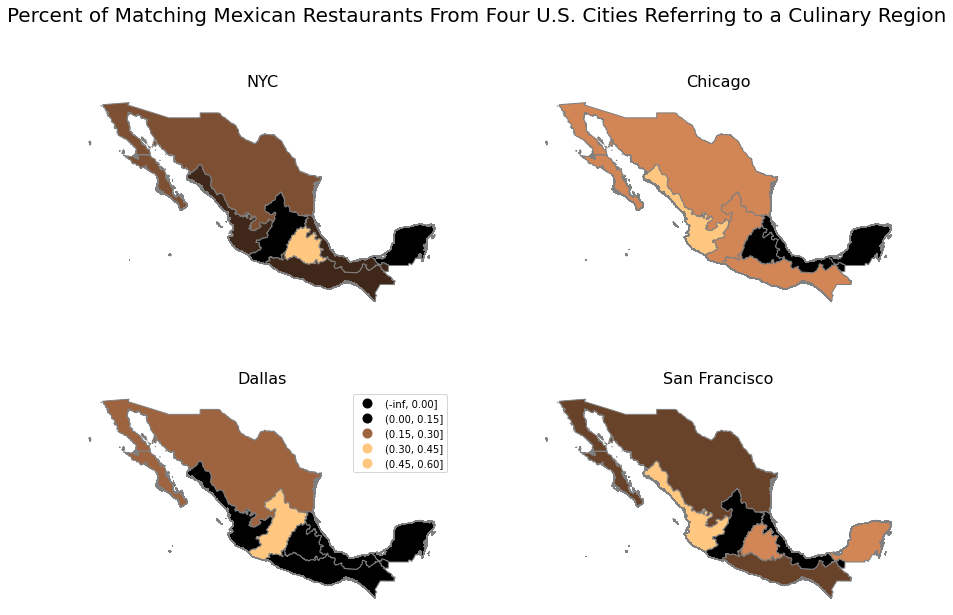

In [65]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Percent of Matching Mexican Restaurants From Four U.S. Cities Referring to a Culinary Region', 
             fontsize=20)
super_region_gdf3.plot(
    column='NYC_pct', ax=ax1, cmap = 'copper', scheme='UserDefined',
              classification_kwds=dict(bins=bin_range_70), edgecolor='gray')
ax1.set_title('NYC', fontsize=16)
super_region_gdf3.plot(
    column='Chi_pct', ax=ax2, cmap = 'copper', scheme='UserDefined',
              classification_kwds=dict(bins=bin_range_70), edgecolor='gray')
ax2.set_title('Chicago', fontsize=16)
super_region_gdf3.plot(
    column='Dal_pct', ax=ax3, cmap = 'copper', scheme='UserDefined',
              classification_kwds=dict(bins=bin_range_70), legend=True, edgecolor='gray')
ax3.set_title('Dallas', fontsize=16)
super_region_gdf3.plot(
    column='SF_pct', ax=ax4, cmap = 'copper', scheme='UserDefined',
              classification_kwds=dict(bins=bin_range_70), edgecolor='gray')
ax4.set_title('San Francisco', fontsize=16)
for ax in (ax1,ax2,ax3,ax4,):
    ax.axis('off')
# plt.savefig("./my_saved_data/Map_of_culinary_regions_from_all_cities.png", 
#             pad_inches='tight', orientation='landscape')

# Conclusions

All 4 cities have [Mexican immigrant populations larger than 250k](https://247wallst.com/economy/2017/01/27/us-cities-with-the-most-mexican-immigrants/). Despite this surface similarity, it turns out that **they don't all come from similar regions in Mexico**. Mexico City, for example, made up 23% of the home regions for San Francisco restaurants but was less than 5% in every other city. The diverse origins of Mexican regions show that **Mexican immigration is from a wide range of regions**. Looking at the combined results map, it's very clear that **Central Mexico sends the most people**, out of all regions in Mexico. The remittances data confirms this finding is represented in reality. It should also be noted, the large relative differences in the home region of people in the U.S. cities here. Puebla, for example, made up 48% of the NYC regions represented. This shows that regional differences are definitely occurring in the U.S. It also shows the role of chain migration in determining the home of new immigrants. This is further exemplified by some cases of it happening in the micro level: "Tulcingo" appears 5 times in the NYC data despite the fact that _Tulcingo del Valle_, Mexico, has only around [9,000 people living in it](https://es.wikipedia.org/wiki/Municipio_de_Tulcingo)! Perhaps this can be a case where more people from that town currently live in NYC than in the town itself! 

## Shortcomings

Some shortcomings of this project are the quality of this data: both for the demonym dictionary and the inspection data. The demonym dictionary had many entries, but there were some clear errors, e.g.: the restaurant 'jalisco' in Dallas was originally associated with "Ciudad de Mexico" instead of the region Jalisco (this was corrected). The names associated with regions were hand corrected by me as a final step. Additionally, it is not clear if **all** restaurants in each city are included in this data. It seems unlikely that Chicago only has 5 restaurants that refer to regions of Mexico given that it is a metro area with some of the most Mexican-born people in the U.S. (at least 5% of the nation's total). In a similar vein, some cities had data that had too low of a quality to be useful (LA). Another problem with this project is deciding when a "match" is legitimate. For example, "Pueblito" ("little town") appeared often and is a town in Queretáro, but do these restaurants refer to this specific town? This was decided on an ad hoc basis and was founded solely on my (non-native) discretion. Lastly, the obvious issue of immediate representation being a marker of the true number of people from a certain region is certainly flawed. Just because there are say, a lot of Italian restaurants in a certain area, does not necessarily mean that there are many (recent) italian immigrants to that area. The popularity of food from certain regions may skew the data. It is my hope, that all regions are represented equally among recent immigrants and that these restaurants are roughly representative of the true Mexican populations of these cities. 

## Past conclusion

All 4 cities have [Mexican immigrant populations larger than 250k](https://247wallst.com/economy/2017/01/27/us-cities-with-the-most-mexican-immigrants/). Despite this surface similarity, it turns out that they don't all come from similar regions in Mexico. No region was in the top 5 most popular region for more than 2 of these cities. This suggests that immigration from Mexico was not dominated by one region but came from all regions of Mexico (except 3: Quintana Roo, Queretaro, Coahuila). Similarly, we see that there are no single region that makes up the majority of any US city's Mexican population: in all cases, no region accounted for more than 40% of the restaurants with regions associated with their names. This did have some variation, however: in San Francisco Guanajuato accounts for 40% of the restaurants while in Dallas the most dominant group accounts for 21% of the population.

As an interesting side note, it appears that chain migration happens at an extremely micro level. "Tulcingo" appears 5 times in the NYC data despite the fact that the town that it refers to in Mexico, Tulcingo del Valle, has only around [9,000 people living in it](https://es.wikipedia.org/wiki/Municipio_de_Tulcingo)! Perhaps this can be a case where more people from that town currently live in NYC than in the town itself! 